# Когортный анализ анализ с Python
1. [Определение/загрузка нужных библиотек и данных](#Libraries)
1. [Первичный анализ](#FirstStep)
1. [Подготовка данных](#NewData) 
1. [Создание вспомогательных таблиц](#Tables) 
1. [Когортный анализ и визуализация](#Report)

---
<a id="Libraries"></a>
## 1. Загрузка библиотек и данных 

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np

In [36]:
df = pd.read_excel('Online Retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

---
<a id="FirstStep"></a>
## 2. Первичный анализ

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

In [38]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [39]:
df.dropna(subset=['CustomerID'], inplace=True)

In [41]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [42]:
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
n_orders 

CustomerID
12346     2
12347     7
12348     4
12349     1
12350     1
         ..
18280     1
18281     1
18282     3
18283    16
18287     3
Name: InvoiceNo, Length: 4372, dtype: int64

In [43]:
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
mult_orders_perc

0.69967978042086

In [44]:
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.97% of customers ordered more than once.


[Text(0, 0.5, '# of customers'),
 Text(0.5, 0, '# of orders'),
 Text(0.5, 1.0, 'Distribution of number of orders per customer')]

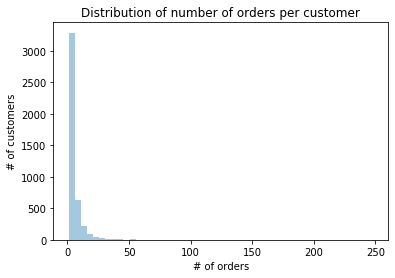

In [45]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers')

---
<a id="NewData"></a>
## 3. Подготовка данных

In [46]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

In [47]:
df['order_month']

0         2010-12
1         2010-12
2         2010-12
3         2010-12
4         2010-12
           ...   
541904    2011-12
541905    2011-12
541906    2011-12
541907    2011-12
541908    2011-12
Name: order_month, Length: 406829, dtype: period[M]

In [48]:
df['cohort']

0         2010-12
1         2010-12
2         2010-12
3         2010-12
4         2010-12
           ...   
541904    2011-08
541905    2011-08
541906    2011-08
541907    2011-08
541908    2011-08
Name: cohort, Length: 406829, dtype: period[M]

In [49]:
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [50]:
#https://docs.python.org/3/library/operator.html
#https://www.kite.com/python/docs/operator.attrgetter

In [51]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4
...,...,...,...,...
86,2011-10,2011-11,93,1
87,2011-10,2011-12,46,2
88,2011-11,2011-11,321,0
89,2011-11,2011-12,43,1


---
<a id="#Report"></a>
## 4. Когортный анализ и визуализация

In [15]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [ ]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

In [52]:
cohort_pivot 

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____
>>> Чтобы получить retention matrix, нам нужно разделить значения каждой строки на
первое значение, которое на самом деле является размером когорты - все клиенты, совершившие первую покупку в данном месяце.

In [53]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [54]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


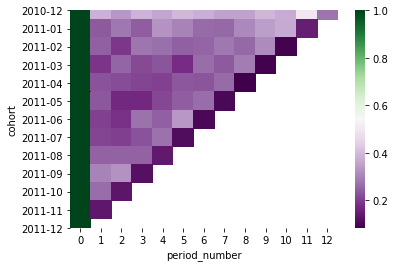

In [69]:
#retention matrix
sns.heatmap(retention_matrix, fmt='.0%', cmap='PRGn') 
plt.show()

>>> Вы можете установить свою палетку
https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html

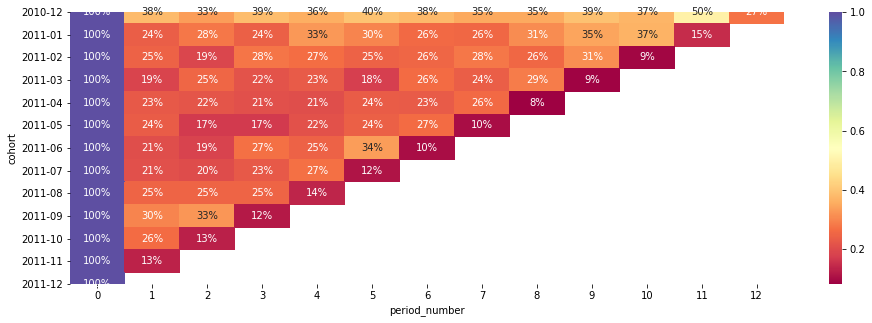

In [72]:
#retention matrix2
plt.figure(figsize=(16,5))
sns.heatmap(retention_matrix, fmt='.0%', annot=True, cmap='Spectral') 
plt.show()

In [74]:
# cohort size - вот что интересно было бы добавить!
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})

In [75]:
cohort_size_df

,cohort_size
cohort,
2010-12,948.0
2011-01,421.0
2011-02,380.0
2011-03,440.0
2011-04,299.0
2011-05,279.0
2011-06,235.0
2011-07,191.0
2011-08,167.0


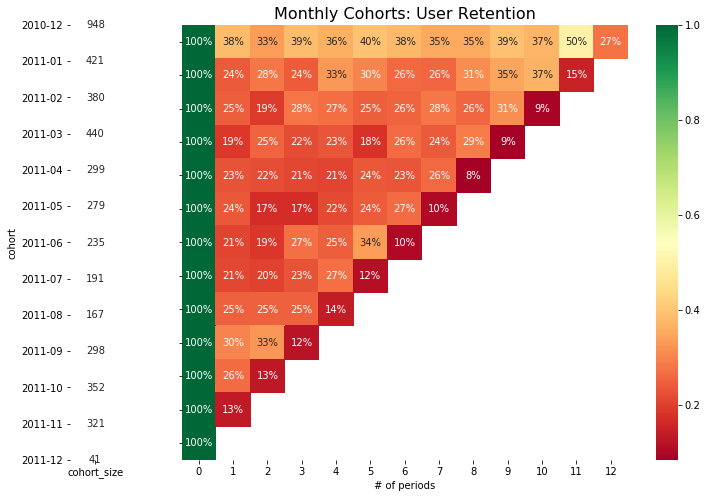

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
# retention matrix
sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
ax[1].set(xlabel='# of periods', ylabel='')


sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
plt.show()

In [77]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
retention_matrix.to_excel(r'retention_matrix.xlsx')
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html